In [1]:
import torch
import os
import sys

Mounted at /content/drive


In [2]:
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import random as rd

In [3]:
def reshape(tensor):
  tensor = torch.squeeze(tensor)
  tensor = torch.flatten(tensor, 0)

  return tensor

class DeepNN(nn.Module):

  def __init__(self):
    super(DeepNN, self).__init__()
    self.layers_outputs = []
    self.linear_stack = nn.Sequential(
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
    )
    self.apply_hooks()



  def forward(self, X):
    self.layers_outputs.clear()
    X = reshape(X)
    X = self.linear_stack(X)
    return X

  def hook_fn(self, module, input, output):
    self.layers_outputs.append(output)

  def apply_hooks(self):
    for i in range(len(self.linear_stack)):
      if isinstance(self.linear_stack[i], torch.nn.modules.linear.Linear):
        self.linear_stack[i].register_forward_hook(self.hook_fn)


In [4]:
def predict(dnn, input):
  output = dnn.forward(input)
  pred = torch.argmax(output, dim = 0)

  return pred, output

In [5]:
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 346kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:02<00:00, 659kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.98MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [61]:
def show_data(tensor):
  tensor = tensor.clone().detach().requires_grad_(False)
  tensor = torch.squeeze(tensor)
  plt.imshow(tensor)

tensor = test_dataset[0][0]

print(len(test_dataset))
print(type(test_dataset[0]))
print(type(test_dataset[0][0]))
print(type(test_dataset[0][1]))
print(tensor.shape)
print(reshape(tensor).shape)

10000
<class 'tuple'>
<class 'torch.Tensor'>
<class 'int'>
torch.Size([1, 28, 28])
torch.Size([784])


In [7]:
class CovTracker():

  def __init__(self, dnn):
    self.dnn = dnn
    self.cov_tracker = []
    self.coverage = 0

  def selection(self, strategie, m):
    sum = 0
    for layer_output in self.dnn.layers_outputs:
      match strategie:

        case 1: # select the m highest weighted outputs
          t, indices = torch.topk(layer_output, m)
          sum += torch.sum(t)
          self.cov_tracker.append(t)
        case 2: # select the m closest to threshold outputs (in this case we use ReLU so treshold equals to 0)
          layer_output_abs = torch.abs(layer_output)
          t, indices = torch.topk(layer_output_abs, m, largest=False)
          sum += torch.sum(t)
          self.cov_tracker.append(t)

    return sum


    def get_coverage(self):
      pass


In [53]:
def Mutation(input_l, dnn, k, m, strategies, lamda, cov_tracker, iter_time, eta, gamma):

  adversarial_set = []
  for x in input_l:

    seed_list = [x]

    while len(seed_list) > 0:

      x_s, label = seed_list.pop(0)
      pred, output = predict(dnn, x_s)
      pred_topk, indices = torch.topk(output, k)
      sum_neurons = cov_tracker.selection(strategies, m)
      obj = (torch.sum(pred_topk) - label) + (lamda * sum_neurons)
      obj.backward()
      grads = x_s.grad

      for i in range(iter_time):

        x_bis = x_s + gamma * grads
        pred_bis, output = predict(dnn, x_bis)
        sum_neurons_bis = cov_tracker.selection(strategies, m)
        L2_dist = torch.linalg.norm(x_s - x_bis)

        if sum_neurons_bis - sum_neurons > 0 and L2_dist < eta:
          seed_list.append((x_bis, label))
          sum_neurons = sum_neurons_bis

        if pred_bis != label:
           adversarial_set.append(x_bis)
           break

  return adversarial_set

# Let's fetch our already trained model

In [9]:
dnn = DeepNN()
cwd = os.getcwd()
path = f"{cwd}/models/model_DeepDNN_MNIST.pt"
dnn.load_state_dict(torch.load(path))
dnn.eval()

<ipython-input-9-1ea72087e564>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dnn.load_state_dict(torch.load(path))


DeepNN(
  (linear_stack): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

# Check our predict function

tensor(3)


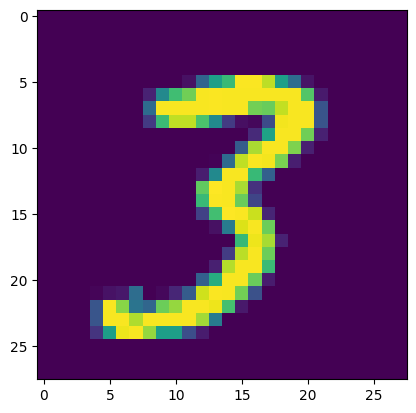

In [20]:
random_tensor = test_dataset[rd.randint(0, 10000)][0]

pred, output = predict(dnn, random_tensor)
print(pred)
show_data(random_tensor)

# Adversarial inputs generation

In [60]:
""" Modify the dataset to allow gradient coverage on the inputs """

def reshape_dataset(dataset, k):
  dataset_reshaped = []
  for i in range(k):
    dataset_reshaped.append((dataset[i][0].clone().detach().requires_grad_(True), dataset[i][1]))
  return dataset_reshaped

In [54]:
cov_tracker = CovTracker(dnn)
dataset = reshape_dataset(test_dataset, 1000)

lamda = 0.01 # how much neuron coverage is taken into acount in the Loss function
eta = 0.002 # distance treshold between adversarial_n-1 and adversarial_n
gamma = 0.002 # gradient step
k = 3 # top k outputs
m = 10 # Iterations

""" Generate the adversarial set """
adversarial_set = Mutation(dataset, dnn, k, m, 1, lamda, cov_tracker, 4, eta, gamma)

In [55]:
print(len(adversarial_set))

47


tensor(0)


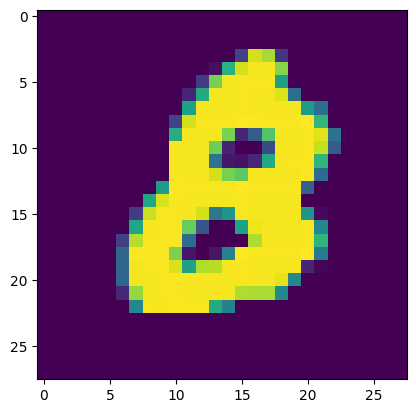

In [88]:
random_adv = adversarial_set[rd.randint(0, len(adversarial_set))]
pred, output = predict(dnn, random_adv)
print(pred)
show_data(random_adv)